In [22]:
import os

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from src.CPQAOA import CP_QAOA
from src.Cirq_CPQAOA import Cirq_CPQAOA
from src.Qsim_CPQAOA import Qsim_CPQAOA
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo)

In [31]:
# Number of Qubits 
N_vals = 10
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Maximal number of iterations for classical solver
max_iter=650
# Using next nearest neighbors (in 1D chain model)
w_nnn = True
# Number of layer repetitions
layer_dict = {3:1, 4:1, 5:1,
              6:2, 7:2, 8:2, 
              9:2, 10:3, 11:3, 
              12:3, 13:3, 14:3,
              15:4, 16:4, 17:4}


initialization_strategies = {N_qubits : np.array([1 if i%2 == 1 else 0 for i in range(N_qubits)]) 
                             for N_qubits in range(min(list(layer_dict.keys())),max(list(layer_dict.keys()))+1)}

N = N_vals
k = N // 2
seed = 3



In [32]:
# Defining topology
my_chain = Chain(N_qubits=N)
my_chain.set_initialization_strategy(strategy=initialization_strategies[N])

# Deciding between grid and 1d chain topology
my_topology = my_chain

# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
#full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])


if not portfolio_subspace_min_state_str == qubo_min_state_str:
    raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}'+f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')

if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
    raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')

if not qubo_max_cost >= portfolio_subspace_max_cost:
    raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')


In [33]:
# Generating instances of ansatz'
QISKIT_ansatz = CP_QAOA(N_qubits=N,
                        cardinality=k,
                        layers=layer_dict[N],
                        topology=my_topology,
                        QUBO_matrix=Q,
                        with_next_nearest_neighbors=w_nnn,
                        approximate_hamiltonian=True)

In [34]:

CIRQ_ansatz = Qsim_CPQAOA(N_qubits=N,
                          cardinality=k,
                          layers=layer_dict[N],
                          topology=my_topology,
                          QUBO_matrix=Q,
                          with_next_nearest_neighbors=w_nnn,
                          approximate_hamiltonian=True,
                          get_full_state_vector=False)


In [35]:

# Choosing optimizer for scipy
optimizer_method = 'COBYLA'

# Generating callback function for plotting
QISKIT_costs = [] # Normalized costs
QISKIT_probs = [] # probability of optimal state
def QISKIT_callback_function(x):
    _dict_ = QISKIT_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        QISKIT_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        QISKIT_probs.append(0)
    QISKIT_costs.append(_cost_)
    
# Generating callback function for plotting
CIRQ_costs = [] # Normalized costs
CIRQ_probs = [] # probability of optimal state
def CIRQ_callback_function(x):
    _dict_ = CIRQ_ansatz.counts
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CIRQ_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CIRQ_probs.append(0)
    CIRQ_costs.append(_cost_)

# Generating initial guess for rotation angles
np.random.seed(seed)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layer_dict[N] * len(my_topology.get_NNN_indices()) if w_nnn else layer_dict[N] * len(my_topology.get_NN_indices()) 
theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)


In [36]:
QISKIT_res = sc.optimize.minimize(fun=QISKIT_ansatz.get_cost, 
                                      x0=theta_i,
                                      method=optimizer_method,
                                      options={'disp': False, 
                                               'maxiter': max_iter},
                                      callback=QISKIT_callback_function)
QISKIT_res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.837339341972908
       x: [ 5.801e-01  3.052e+00 ... -1.277e+00 -3.452e+00]
    nfev: 650
   maxcv: 0.0

In [37]:
CIRQ_res = sc.optimize.minimize(fun=CIRQ_ansatz.get_cost, 
                                x0=theta_i,
                                method=optimizer_method,
                                options={'disp': False, 
                                           'maxiter': max_iter},
                                callback=CIRQ_callback_function)

CIRQ_res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.8301060616513825
       x: [ 6.180e-01  2.929e+00 ... -1.216e+00 -3.430e+00]
    nfev: 650
   maxcv: 0.0

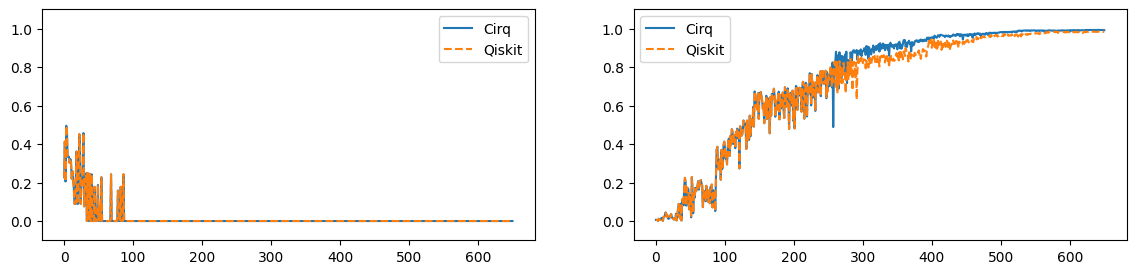

In [38]:
fig, ax = plt.subplots(1,2,figsize=(14,3))
ax[0].plot([it for it in range(len(CIRQ_costs))], CIRQ_costs, label='Cirq')
ax[0].plot([it for it in range(len(QISKIT_costs))], QISKIT_costs, ls='--', label='Qiskit')
ax[0].legend()
ax[0].set_ylim(-0.1,1.1)

ax[1].plot([it for it in range(len(CIRQ_probs))], CIRQ_probs, label='Cirq')
ax[1].plot([it for it in range(len(QISKIT_probs))], QISKIT_probs,ls='--', label='Qiskit')
ax[1].legend()
ax[1].set_ylim(-0.1,1.1)
plt.show()